In [1]:
# Import standard Python data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import classes from scikit-learn for logistic regression, least squares linear regression
# Import OneHotEncoder and PolynomialFeatures for data pre-processing
# Import Pipeline, ColumnTransformer to encapsulate pre-processing heterogenous data and fitting
# into a single estimator
# Import train_test_split, cross_val_score, LeaveOneOut, KFold for model validation
# Import resample for bootstrapping
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would use the StatsModels Formula API
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Applied Exercise 1

**In Chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set. We will now estimate the test error of this logistic regression model using te validation set approach. Do not forget to set a random seed before beginning your analysis.**

In [2]:
default_filepath = "Default.csv"
Default = pd.read_csv(default_filepath)
Default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


## Part 1
**Fit a logistic regression model that uses `income` and `balance` to predict `default`.**

For this part, we use the entire data set to fit a logisic regression model to predict `default` by using `income` and `balance`.

In [3]:
X = Default[["balance", "income"]]
y = Default["default"]
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
clf.fit(X, y)
clf.coef_

array([[5.64710291e-03, 2.08089921e-05]])

## Part 2
**Using the validation set approach, estimate the test error of this model. In order to do this, youmust perform the following steps:**

1. **Split the sample into a training set and a validation set.**
2. **Fit a multiple logistic regression model using only the training observations.**
3. **Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the `default` category if the posterior probability is greater than 0.5.**
4. **Compute the validation set error, which is the fraction of observations in the validation set that are misclassified.**

I will use a 75-25 split when dividing my data into a training set and a validation set. To split the data into a training set and a validation set, we use `train_test_split()`. Note that we passed a value to the `random_state` argument to have reproducible results. After fitting the logistic regression model using the training observations, scikit-learn performs steps 3 and 4 (obtaining predictions using a posterior probability threshold of 0.5 and then computing the validation set accuracy) in a single step via the `score()` function. Note that if we wished to make predictions using a posterior probability threshold other than 0.5, we would want to use the `predict_proba()` function to obtain the posterior probabilities of each class for each observation in the validation set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(Default[["balance", "income"]], Default["default"],
                                                   test_size = 0.25, random_state = 312)
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
clf.fit(X_train, y_train)
1 - clf.score(X_test, y_test)

0.02839999999999998

For this train-test split, we had a validation set error of 0.0284, or 2.84% of the observations in the validation set that are misclassified.

## Part 3
**Repeat the process in Part 2 three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(Default[["balance", "income"]], Default["default"],
                                                   test_size = 0.25, random_state = 456)
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
clf.fit(X_train, y_train)
1 - clf.score(X_test, y_test)

0.03200000000000003

In [6]:
X_train, X_test, y_train, y_test = train_test_split(Default[["balance", "income"]], Default["default"],
                                                   test_size = 0.25, random_state = 789)
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
clf.fit(X_train, y_train)
1 - clf.score(X_test, y_test)

0.034399999999999986

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Default[["balance", "income"]], Default["default"],
                                                   test_size = 0.25, random_state = 314159)
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
clf.fit(X_train, y_train)
1 - clf.score(X_test, y_test)

0.031200000000000006

In [8]:
(Default["default"] != "No").mean()

0.0333

Using three different 75-25 splits of the data, our validation set error remained fairly consistent. The average error between this part and Part 2 was 0.0315, and errors were all within about 20% of each other. We also note, however, that these test errors are all fairly close to the error one would achieve with a naive strategy of just saying that nobody will default. The average of the test errors is only about 5% less than the error from using the naive strategy.

## Part 4
**Now consider a logistic regression model that predicts the probability of `default` using `income`, `balance`, and a dummy variable for `student`. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for `student` leads to a reduction in the test error rate.**

In [9]:
np.random.seed(312)
with_student = {}
without_student = {}

# Create two classifier pipelines
# with_student takes the student variable and encodes it using one hot encoding, passes through income, balance
# without_student drops the student variable and only passes through income and balance
categorical_features = ["student"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["income", "balance"]
with_student_preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
with_student_clf = Pipeline([("preprocessor", with_student_preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs"))])
without_student_preprocessor = ColumnTransformer([("num", "passthrough", numerical_features)])
without_student_clf = Pipeline([("preprocessor", without_student_preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs"))])

# Loop through 50 train-test splits to compute average difference in error rate
for i in range(50):
    # Split the data in to training and test sets
    X_train, X_test, y_train, y_test = train_test_split(Default, Default["default"], test_size = 0.25)
    # Fit classifier which includes student variable and compute validation set error
    with_student_clf.fit(X_train, y_train)
    with_student[i] = 1 - with_student_clf.score(X_test, y_test)
    # Fit classifier which excludes student variable and compute validation set error
    without_student_clf.fit(X_train, y_train)
    without_student[i] = 1 - without_student_clf.score(X_test, y_test)
errors = pd.DataFrame({"with_student": with_student, "without_student": without_student})
errors["difference"] = errors["with_student"] - errors["without_student"]
errors["difference"].mean()

0.0021280000000000075

Looping through 50 train-test splits and comparing the error rates between the logistic regression model predicting `default` using `income`, `balance`, and `student` and the logistic regression model predicting `default` using just `income` and `balance` for each split, we see that, on average, including a dummy variable for `student` does not lead to a reduction in the test error rate. In fact, on average it resulted in a very slight increase in the test error rate.

# Applied Exercise 2

**We continue to consider the use of a logistic regression model to predict the probability of `default` using `income` and `balance` on the `Default` data set. In particular, we will now compute estimates for the standard errors of the `income` and `balance` logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the `Logit` class in StatsModels. Do not forget to set a random seed before beginning your analysis.**

## Part 1
**Using the `Logit` class in StatsModels, determine the estimated standard errors for the coefficients associated with `income` and `balance` in a multiple logistic regression model that uses both predictors.**

In [10]:
# Using the Logit class from StatsModels
# First encode response numerically
endog = (Default["default"] == "Yes").astype(int)
exog = sm.add_constant(Default[["income", "balance"]])
mod = sm.Logit(endog, exog)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
res.bse["income"]

4.985245461753051e-06

In [12]:
res.bse["balance"]

0.00022738138476844716

Using the `Logit` class in StatsModels, the estimated standard error for the estimated coefficient of `income` is $4.985 \times 10^{-6}$, while the estimated standard error for the estimated coefficient of `balance` is $2.274 \times 10^{-4}$. Note that we also could have used the `GLM` class in StatsModels as well. The difference between the classes for [regression with a discrete dependent variable](https://www.statsmodels.org/stable/discretemod.html) and those for [generalized linear models](https://www.statsmodels.org/stable/glm.html) are negligible when we are performing logistic regression, but are more meaningful for other regression situations.

## Part 2

**Write a function, `boot_fn()` that takes as input the a sample of the `Default` data and a scikit-learn classifier model object, and that outputs the coefficient estimates for `income` and `balance` in the multiple logistic regression model.**

In [13]:
def boot_fn(data, clf):
    clf.fit(data[["income", "balance"]], data["default"])
    return clf.coef_

## Part 3
**Use the `resample()` fuction together with your `boot_fn()` function to estimate the standard errors of the logistic regression coefficients for `income` and `balance` using the bootstrap.**

In [14]:
np.random.seed(17)
num_estimates = 10000
boot_estimates = np.empty((num_estimates, 2))
for i in range(num_estimates):
    clf = LogisticRegression(penalty = "none", solver = "lbfgs")
    sample = resample(Default)
    coefs = boot_fn(sample, clf)
    boot_estimates[i, 0] = coefs[0, 0]
    boot_estimates[i, 1] = coefs[0, 1]

In [15]:
boot_df = pd.DataFrame(boot_estimates, columns = ["income", "balance"])

In [16]:
boot_df["income"].std()

7.334947123816397e-05

In [17]:
boot_df["balance"].std()

0.0025923464483329217

When using scikit-learn the bootstrap estimates for the standard errors of the logistic regression coefficients appear to be off by an order of magnitude. We can compare with the standard errors obtained when performing the bootstrap (using the same random seed for resampling) with StatsModels.

In [18]:
np.random.seed(17)
num_estimates = 10000
boot_estimates = np.empty((num_estimates, 2))
for i in range(num_estimates):
    sample = resample(Default)
    endog = (sample["default"] == "Yes").astype(int)
    exog = sm.add_constant(sample[["income", "balance"]])
    mod = sm.Logit(endog, exog)
    res = mod.fit(disp = False)
    boot_estimates[i, 0] = res.params["income"]
    boot_estimates[i, 1] = res.params["balance"]
sm_df = pd.DataFrame(boot_estimates, columns = ["income", "balance"])

C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [19]:
sm_df["income"].std()

4.858313148393596e-06

In [20]:
sm_df["balance"].std()

0.00022847275797215077

The estimates for the standard errors of the logistic regression coefficients obtained when performing the bootstrap with StatsModels are much more in-line with the expected values when compared to the values I obtained from doing this exercise in R and also with the estimates from Part 1. Looking more closely at the coefficient estimates obtained from each bootstrap sample, we see that the coefficients obtained using scikit-learn have some strange values that do not match those obtained using StatsModels on the same sample. I think that this might be due to convergence issues that the underlying solver for scikit-learn's implementation of logistic regression encountered for certain samples, where the solver converges to a solution, but not the correct one due to aspects of the sample.

In [21]:
coef_comparison = boot_df.join(sm_df, rsuffix = "_sm")
coef_comparison.head()

,income,balance,income_sm,balance_sm
0,-0.000127,0.000472,0.000020,0.005557
1,0.000024,0.005767,0.000024,0.005767
2,-0.000118,0.000331,0.000030,0.005479
3,0.000024,0.005686,0.000024,0.005686
4,-0.000125,0.000422,0.000016,0.005687


In [22]:
coef_comparison[np.isclose(coef_comparison["income"], coef_comparison["income_sm"])].shape

(4316, 4)

Using the [NumPy `isclose()` function](https://numpy.org/doc/1.16/reference/generated/numpy.isclose.html), we see that scikit-learn seemed to encounter convergence issues when estimating the logistic regression coefficients for about 57% of the bootstrap samples. If we look specifically at those samples which had convergence issues, then the bootstrap estimates for the standard errors of the scikit-learn coefficients are more in-line with those for the StatsModels coefficients. This suggests that the convergence issues scikit-learn encountered for certain bootstrap samples at least resulted in convergence to consistently incorrect coefficient estimates without too much variability.

In [23]:
close_coefs = np.isclose(coef_comparison["income"], coef_comparison["income_sm"])

In [24]:
coef_comparison[~close_coefs].mean()

income       -0.000126
balance       0.000438
income_sm     0.000020
balance_sm    0.005680
dtype: float64

In [25]:
coef_comparison.loc[~close_coefs, "income"].std()

8.752961708662195e-06

In [26]:
coef_comparison.loc[~close_coefs, "income_sm"].std()

4.8768575616908896e-06

In [27]:
coef_comparison.loc[~close_coefs, "balance"].std()

0.0002805718618190253

In [28]:
coef_comparison.loc[~close_coefs, "balance_sm"].std()

0.00023018058778552966

To finish, we look at the estimated standard errors for the logistic regression coefficients for the bootstrap samples which did not cause scikit-learn to experience convergence issues. The estimates from scikit-learn and StatsModels agree up to five significant figures.

In [29]:
coef_comparison.loc[close_coefs, "income"].std()

4.770940015481915e-06

In [30]:
coef_comparison.loc[close_coefs, "income_sm"].std()

4.770947342643109e-06

In [31]:
coef_comparison.loc[close_coefs, "balance"].std()

0.00022469643206981835

In [32]:
coef_comparison.loc[close_coefs, "balance_sm"].std()

0.0002246953718114099

Using the bootstrap, the estimated standard errors of the logistic regression coefficients for `income` and `balance` are $4.771 \times 10^{-6}$ and $2.247 \times 10^{-4}$, respectively.

## Part 4

**Comment on the estimated standard errors obtained using the `Logit` class and using your bootstrap function.**

The standard errors obtained by the bootstrap appear to be a quite close to those obtained using the statistical formulas underlying the `Logit` class. However, as mentioned above, it appeared that scikit-learn encountered convergence issues when estimating the coefficients for certain bootstrap samples. After separating the bootstrap coefficient estimates into two categories: those which resulted from scikit-learn convergence issues and those which did not, we saw that the estimated standard errors for the coefficients within each category were fairly close to those obtained using statistical formulas underlying the `Logit` class. This suggests that the data satisfies the underlying assumptions of a logistic regression model: the responses $Y_i$ are independent random variables coming from Bernoulli distributions with probabilities $P_i$, and the log-odds corresponding to $P_i$ is a linear combination of the predictors.

# Applied Exercise 3

**In Sections 5.3.2 and 5.3.3, we saw that the `cross_val_score()` function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just the `fit()` and `score()` functions for a `LogisticRegression` object, and a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the `Weekly` data set. Recall that in the context of classification problems, the LOOCV error is given by the following formula.**

\begin{equation}
    \text{CV}_{(n)} = \frac{1}{n} \sum_{i = 1}^n I(y_i \neq \hat{y}_i)
\end{equation}

In [33]:
weekly_filepath = "Weekly.csv"
weekly = pd.read_csv(weekly_filepath)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


## Part 1
**Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2`.**

In [35]:
X = weekly[["Lag1", "Lag2"]]
y = weekly["Direction"]
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
clf.fit(X, y)
print(clf.coef_, clf.intercept_)

[[-0.03872222  0.0602483 ]] [0.22122405]


## Part 2
**Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2` *using all but the first observation*.**

In [37]:
X_loo = weekly.loc[weekly.index != 0, ["Lag1", "Lag2"]]
y_loo = weekly.loc[weekly.index != 0, "Direction"]
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
clf.fit(X_loo, y_loo)
print(clf.coef_, clf.intercept_)

[[-0.03843317  0.06084763]] [0.22324305]


## Part 3
**Use the model from Part 2 to predict the direction of the first observation. You can do this by predicting that the first observation will go up if $P(\text{Direction} = \text{"Up"} | \text{Lag1, Lag2}) > 0.5$. Was this observation correctly classified?**

In [49]:
clf.predict_proba(weekly.loc[0, ["Lag1", "Lag2"]].to_frame().T)

array([[0.42860768, 0.57139232]])

In [50]:
clf.predict(weekly.loc[0, ["Lag1", "Lag2"]].to_frame().T)

array(['Up'], dtype=object)

In [51]:
weekly.iloc[0]

Year             1990
Lag1            0.816
Lag2            1.572
Lag3           -3.936
Lag4           -0.229
Lag5           -3.484
Volume       0.154976
Today           -0.27
Direction        Down
Name: 0, dtype: object

Using the model from Part 2, we predict that the first observation will go up, since the predicted posterior probability from the model is 0.4286 that the direction will be down and 0.5714 that the direction will be up. This observation was incorrectly classified.

## Part 4
**Write a for loop from $i = 1$ to $i = n$, where $n$ is the number of observations in the data set, that performs each of the following steps:**

1. **Fit a logistic regression model using all but the $i$th observation to predict `Direction` using `Lag1` and `Lag2`.**
2. **Compute the posterior probability of the market moving up for the $i$th observation.**
3. **Use the posterior probability for the $i$th observation in order to predict whether or not the market moves up.**
4. **Determine whether or not an error was made in predicting the direction for the $i$th observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.**

In [57]:
n = weekly.shape[0]
scores = np.empty(n)
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
for i in range(n):
    X_loo = weekly.loc[weekly.index != i, ["Lag1", "Lag2"]]
    y_loo = weekly.loc[weekly.index != i, "Direction"]
    clf.fit(X_loo, y_loo)
    scores[i] = clf.score(weekly.loc[i, ["Lag1", "Lag2"]].to_frame().T, pd.Series(weekly.loc[i, "Direction"]))

## Part 5
**Take the average of the $n$ numbers obtained in Step 4 of Part 4 in order to obtain the LOOCV estimate for the test error. Comment on the results.**

In [58]:
scores.mean()

0.5500459136822773

In [59]:
errors = 1 - scores
errors.mean()

0.44995408631772266

In [62]:
# Using cross_val_score to compare results with LeaveOneOut splitter
X = weekly[["Lag1", "Lag2"]]
y = weekly["Direction"]
clf = LogisticRegression(penalty = "none", solver = "lbfgs")
loo = LeaveOneOut()
cv_scores = cross_val_score(clf, X, y, cv = loo)
cv_scores.mean()

0.5500459136822773

In [63]:
1 - cv_scores.mean()

0.4499540863177227

In [64]:
(weekly["Direction"] != "Up").mean()

0.4444444444444444

The LOOCV estimate for the test error is approximately 0.45, which matches the value we get if we use `cross_val_score()` with the `LeaveOneOut()` splitter to compute the error. This tells us that the logistic regression model using `Lag1` and `Lag2` to predict `Direction` by using a probability threshold of 0.5 performed a bit better than randomly guessing. However, it is important to note that we get essentially the same error rate with a naive strategy of predicting that the market will go up every week. 

Note that when using `cross_val_score` to compute the LOOCV test error, it computes scores using the `score()` function associated with the estimator class by default. In the case of logistic regression with two classes, this is the accuracy score computed using a posterior probability threshold of 0.5. However, it is important to note that performing classification using logistic regression like we have done in this chapter involves choosing a probability threshold for assigning class predictions, based on the posterior probabilities predicted by the logistic regresion model. Since on its own logistic regression is ***not*** a classification method, we may wish to instead compute scores/errors associated with the posterior probabilities instead. To do that, we should either pick one of the [scorers or metrics as discussed in the scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and supply that for the `scoring` argument.

# Applied Exercise 4

**We will now perform cross-validation on a simulated data set.**

## Part 1
**Generate a simulated data set as follows:**

```
> np.random.seed(312)
> x = np.random.normal(size = 100)
> y = x - 2*x**2 + np.random.normal(size = 100)
```

**In this data set, what is $n$ and what is $p$? Write out the model used to generate the data in equation form.**

In [65]:
np.random.seed(312)
x = np.random.normal(size = 100)
y = x - 2*x**2 + np.random.normal(size = 100)

In this data set, $n = 100$ and $p = 1$. In other words, there is one predictor and 100 observations. In equation form, the model used to generate the data is $Y = X - 2X^2 + \epsilon$.

## Part 2
**Create a scatterplot of $X$ against $Y$. Comment on what you find.**

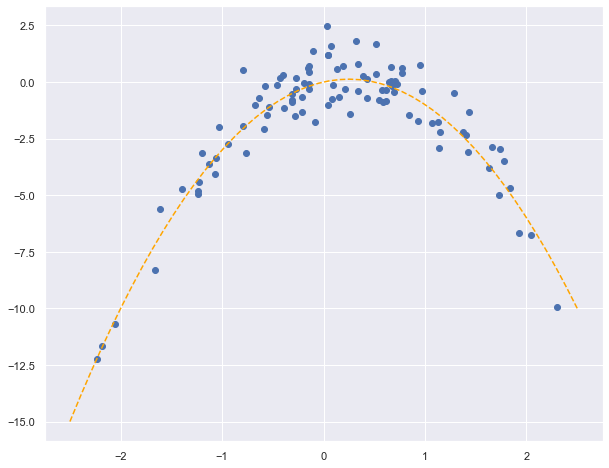

In [73]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.scatter(x, y)

#Plot parabola used to model the data set
x_range = np.linspace(start = -2.5, stop = 2.5)
parabola = x_range - 2*x_range**2
ax.plot(x_range, parabola, color = "orange", linestyle = "--");

While there is some noise, especially around the vertex of parabola for the model underlying the data, we can see that for the most part the scatterplot is fairly parabolic.

## Part 3
**Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:**

1. $Y = \beta_0 + \beta_1X + \epsilon$
2. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
3. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$
4. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$

**Note that you may find it helpful to use the `pandas.DataFrame()` function to create a single dataset containing both $X$ and $Y$.**

In [81]:
np.random.seed(312)
loocv_scores = pd.Series()
for i in range(1, 5):
    poly_reg = Pipeline([("poly", PolynomialFeatures(degree = i)), ("reg", LinearRegression())])
    loo = LeaveOneOut()
    cv_scores = cross_val_score(poly_reg, x.reshape(-1, 1), y, scoring = "neg_mean_squared_error", cv = loo)
    loocv_scores.loc[i] = abs(cv_scores.mean())
loocv_scores

1    8.015655
2    0.807797
3    0.823459
4    0.827053
dtype: float64

We have the following LOOCV errors.

- For the linear model $Y = \beta_0 + \beta_1X + \epsilon$ it is 8.016.
- For the quadratic model $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$ it is 0.808.
- For the cubic model $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$ it is 0.823.
- For the quartic model $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$ it is 0.827.

## Part 4
**Repeat Part 3 using another random seed, and report your results. Are your results the same as what you got in Part 3? Why or why not?**

In [82]:
np.random.seed(42)
loocv_scores = pd.Series()
for i in range(1, 5):
    poly_reg = Pipeline([("poly", PolynomialFeatures(degree = i)), ("reg", LinearRegression())])
    loo = LeaveOneOut()
    cv_scores = cross_val_score(poly_reg, x.reshape(-1, 1), y, scoring = "neg_mean_squared_error", cv = loo)
    loocv_scores.loc[i] = abs(cv_scores.mean())
loocv_scores

1    8.015655
2    0.807797
3    0.823459
4    0.827053
dtype: float64

The LOOCV errors for each model are the same as those computed in Part 3, even with a different seed. This makes sense since LOOCV does not involve any randomness. It always involves fitting a model $\mathcal{M}_i$ using all of the observations except for observation $X_i$, computing the error between the predicted value $\hat{Y}_i$ obtained from the model $\mathcal{M}_i$ and the actual value $Y_i$, and then taking the average of the errors over all $n$ models for the $n$ observations in the data set.

## Part 5
**Which of the models in Part 3 had the smallest LOOCV error? Is this what you expected? Explain your answer.**

The quadratic model in Part 3 had the smallest LOOCV error, though the cubic and quartic models also had close LOOCV error values, especially compared to the much larger LOOCV error value for the linear model. This is what I expected, since the true model used to produce the simulated data was a quadratic one.

## Part 6
**Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in Part 3 using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?**

Note that we orthogonalize the polynomials for each of the higher-order polynomial fits py using a QR decomposition, as orthogonal polynomials allows for more clear evaluation of the statistical significance of the coefficient estimates for the higher order terms.

In [91]:
poly = PolynomialFeatures(degree = 1, include_bias = True)
# Orthogonalize the powers of the predictor using QR decomposition
ortho_X = np.linalg.qr(poly.fit_transform(x.reshape(-1, 1)))[0][:, 1:]
exog = sm.add_constant(ortho_X)
endog = y
mod = sm.OLS(endog, exog)
res = mod.fit()
print(res.summary())
print("\np-values: ", res.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     5.012
Date:                Tue, 28 Jan 2020   Prob (F-statistic):             0.0274
Time:                        16:17:04   Log-Likelihood:                -241.53
No. Observations:                 100   AIC:                             487.1
Df Residuals:                      98   BIC:                             492.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6505      0.274     -6.033      0.0

In the linear model, the coefficient estimate is statistically significant at the 5% level. This result agrees with the high LOOCV error obtained in Part 3, which suggested that a purely linear fit was not appropriate.

In [92]:
poly = PolynomialFeatures(degree = 2, include_bias = True)
# Orthogonalize the powers of the predictor using QR decomposition
ortho_X = np.linalg.qr(poly.fit_transform(x.reshape(-1, 1)))[0][:, 1:]
exog = sm.add_constant(ortho_X)
endog = y
mod = sm.OLS(endog, exog)
res = mod.fit()
print(res.summary())
print("\np-values: ", res.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     441.9
Date:                Tue, 28 Jan 2020   Prob (F-statistic):           1.85e-49
Time:                        16:17:16   Log-Likelihood:                -128.34
No. Observations:                 100   AIC:                             262.7
Df Residuals:                      97   BIC:                             270.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6505      0.089    -18.615      0.0

In the quadratic model, both coefficient estimates are highly statistically significant. In particular, the p-values for the coefficients of both the quadratic and linear terms are essentially zero. This agrees with the large drop in LOOCV error going from the linear fit to the quadratic fit, which suggested that a quadratic fit was more appropriate than a purely linear one.

In [93]:
poly = PolynomialFeatures(degree = 3, include_bias = True)
# Orthogonalize the powers of the predictor using QR decomposition
ortho_X = np.linalg.qr(poly.fit_transform(x.reshape(-1, 1)))[0][:, 1:]
exog = sm.add_constant(ortho_X)
endog = y
mod = sm.OLS(endog, exog)
res = mod.fit()
print(res.summary())
print("\np-values: ", res.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     292.2
Date:                Tue, 28 Jan 2020   Prob (F-statistic):           3.98e-48
Time:                        16:17:53   Log-Likelihood:                -128.24
No. Observations:                 100   AIC:                             264.5
Df Residuals:                      96   BIC:                             274.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6505      0.089    -18.538      0.0

In the cubic model, the linear and quadratic terms are both highly statistically significant, but the cubic term is not. In particular, the p-value for the cubic term is 0.653, which is quite high. This agrees with the fact that while the LOOCV error for the cubic fit is still much lower than the LOOCV error for the linear fit, it is slightly higher than this LOOCV error for the quadratic fit, which suggests that a quadratic fit is likely to be more appropriate than a cubic fit.

In [94]:
poly = PolynomialFeatures(degree = 4, include_bias = True)
# Orthogonalize the powers of the predictor using QR decomposition
ortho_X = np.linalg.qr(poly.fit_transform(x.reshape(-1, 1)))[0][:, 1:]
exog = sm.add_constant(ortho_X)
endog = y
mod = sm.OLS(endog, exog)
res = mod.fit()
print(res.summary())
print("\np-values: ", res.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     220.2
Date:                Tue, 28 Jan 2020   Prob (F-statistic):           3.87e-47
Time:                        16:18:59   Log-Likelihood:                -127.55
No. Observations:                 100   AIC:                             265.1
Df Residuals:                      95   BIC:                             278.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6505      0.089    -18.569      0.0

In the quartic model, the linear and quadratic terms are both highly statistically significant, but the cubic and quartic terms are not. In particular, the p-values for the cubic and quartic terms are 0.652 and 0.254, respectively, which are quite high. This agrees with the fact that while the LOOCV error for the quartic fit is still much lower than the LOOCV error for the linear fit, it is slightly higher than this LOOCV error for the quadratic fit, which suggests that a quadratic fit is likely to be more appropriate than a quartic fit.

# Applied Exercise 5
**We'll we now consider the `Boston` housing data set.**

We import the scipy stats library for use later on in this exercise.

In [2]:
from scipy import stats

In [4]:
boston_filepath = "boston_corrected.csv"
index_cols = ["TOWN", "TRACT"]
data_cols = ["TOWN", "TRACT", "CMEDV", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
            "PTRATIO", "B", "LSTAT"]
boston = pd.read_csv(boston_filepath, index_col = index_cols, usecols = data_cols)
boston.head()

CMEDV     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE  \
TOWN       TRACT                                                          
Nahant     2011    24.0  0.00632  18.0   2.31     0  0.538  6.575  65.2   
Swampscott 2021    21.6  0.02731   0.0   7.07     0  0.469  6.421  78.9   
           2022    34.7  0.02729   0.0   7.07     0  0.469  7.185  61.1   
Marblehead 2031    33.4  0.03237   0.0   2.18     0  0.458  6.998  45.8   
           2032    36.2  0.06905   0.0   2.18     0  0.458  7.147  54.2   

                     DIS  RAD  TAX  PTRATIO       B  LSTAT  
TOWN       TRACT                                            
Nahant     2011   4.0900    1  296     15.3  396.90   4.98  
Swampscott 2021   4.9671    2  242     17.8  396.90   9.14  
           2022   4.9671    2  242     17.8  392.83   4.03  
Marblehead 2031   6.0622    3  222     18.7  394.63   2.94  
           2032   6.0622    3  222     18.7  396.90   5.33

## Part 1
**Based on this data set, provide an estimate for the population mean of `CMEDV`. Call this estimate $\hat{\mu}$.**

In [5]:
boston["CMEDV"].mean()

22.528853754940716

The estimated population mean of `CMEDV` is $\hat{\mu} = 22.529$. In other words, the average median home value for this sample is \$22,529.

## Part 2
**Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.**

***Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.***

In [6]:
sample_sd = boston["CMEDV"].std()
sample_sd / boston.shape[0]**0.5

0.40819750782840736

Using the [usual formula for estimating the standard error](https://en.wikipedia.org/wiki/Standard_error), we get a value of 0.408 as our estimate for the standard error of $\hat{\mu}$. Since `CMEDV` was measured in units of 1,000 USD, this estimate of the standard error translates to \$408. We will further interpret what this estimate of standard error means in Part 4. Note that we can also use the `Series.sem()` function to directly compute the standard error of the sample mean.

In [7]:
boston["CMEDV"].sem()

0.40819750782840736

## Part 3
**Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from Part 2?**

In [9]:
np.random.seed(312)
n_bootstraps = 10000
means = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    sample = resample(boston["CMEDV"])
    means[i] = sample.mean()
print("Bootstrap estimate of mean: ", means.mean())
print("Bootstrap estimate of std. error: ", means.std(ddof = 1))

Bootstrap estimate of mean:  22.52534049407115
Bootstrap estimate of std. error:  0.40901136594703136


Using the bootstrap, we have an estimate of 0.409 for the standard error of $\hat{\mu}$. This is very close to the estimate obtained in Part 3.

## Part 4
**Based on your bootstrap estimate from Part 3, provide a 95% confidence interval for the mean of `CMEDV`. Compare it to the results obtained using `scipy.stats.t.interval()`.**

***Hint: You can approximate a 95% confidence interval using the formula $[ \hat{\mu} - 2\text{SE}(\hat{\mu}), \hat{\mu} + 2\text{SE}(\hat{\mu}) ]$.***

In [10]:
stats.t.interval(0.95, boston.shape[0] - 1, loc = boston["CMEDV"].mean(), scale = boston["CMEDV"].sem())

(21.72687928010855, 23.33082822977288)

Based on our bootstrap estimate from Part 3, a 95% confidence interval for the mean of `CMEDV` is approximately $[22.529 - 2 \times 0.409, \, 22.529 + 2 \times 0.409]$, or $[21.711, \, 23.347]$. This is slightly wider than the confidence interval computed using `t.test()`, since we rounded our critical $t$-value up to 2, when for our data set with 506 observations the actual critical $t$-value is approximately 1.960. The meaning of a 95% confidence interval is that if we repeatedly sampled from the population and used the sample means and estimated standard errors to compute many confidence intervals, approximately 95% of those confidence intervals will contain the actual population mean. In other words, there is a 95% chance that this confidence interval contains the actual population mean of `CMEDV`.

## Part 5
**Based on this dataset, provide an estimate, $\hat{\mu}_{\text{med}}$, for the median value of `CMEDV` in the population.**

In [11]:
boston["CMEDV"].median()

21.2

The estimated population median of `CMEDV` is $\hat{\mu}_{\text{med}} = 21.2$. In other words, the median of median home values for this sample is \$21,200.

## Part 6
**We would now like to estimate the standard error of $\hat{\mu}_{\text{med}}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.**

In [14]:
np.random.seed(312)
n_bootstraps = 10000
medians = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    sample = resample(boston["CMEDV"])
    medians[i] = sample.median()
print("Bootstrap estimate of median: ", medians.mean())
print("Bootstrap estimate of std. error: ", medians.std(ddof = 1))

Bootstrap estimate of median:  21.179235
Bootstrap estimate of std. error:  0.3805279817956791


Using the bootstrap, we have an estimate of 0.381 for the standard error of $\hat{\mu}_{\text{med}}$. Based on this bootstrap estimate, a 95% confidence interval for the median of `CMEDV` is approximately $[21.2 - 2 \times 0.381, \, 21.2 + 2 \times 0.381]$, or $[20.438, \, 21.962]$. There is a 95% chance that this confidence interval contains the actual population median of `CMEDV`.

## Part 7
**Based on this data set, provide an estimate for the tenth percentile of `CMEDV` in Boston suburbs. Call this quantity $\hat{\mu}_{0.1}$. To compute this estimate, you can use the `Series.quantile()` function.**

In [13]:
boston["CMEDV"].quantile(0.1)

12.9

The estimated population tenth percentile of `CMEDV` is $\hat{\mu}_{0.1} = 12.9$. In other words, the tenth percentile of median home values for this sample is \$12,900, or only 10% of observations in this sample have a `CMEDV` value of 12.9 or less.

## Part 8
**Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.**

In [16]:
np.random.seed(312)
n_bootstraps = 10000
tenth_percs = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    sample = resample(boston["CMEDV"])
    tenth_percs[i] = sample.quantile(0.1)
print("Bootstrap estimate of tenth percentile: ", tenth_percs.mean())
print("Bootstrap estimate of std. error: ", tenth_percs.std(ddof = 1))

Bootstrap estimate of tenth percentile:  12.81746
Bootstrap estimate of std. error:  0.4975323127599091


Using the bootstrap, we have an estimate of 0.498 for the standard error of $\hat{\mu}_{0.1}$. Based on this bootstrap estimate, a 95% confidence interval for the tenth percentile of `CMEDV` is approximately $[12.9 - 2 \times 0.498, \, 12.9 + 2 \times 0.498]$, or $[11.904, \, 13.896]$. There is a 95% chance that this confidence interval contains the actual population tenth percentile of `CMEDV`.